# Cylindrical compressive test

In [1]:
from ibvpy.bcond import BCSlice
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic
from bmcs_matmod.ms1.ms1 import MS13D
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from mayavi import mlab
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym

import numpy as np


In [2]:
from bmcs_expsim.utils.mlab_decorators import decorate_figure

# a = pi r**2
# r = np.sqrt( a / pi )

unit_radius = np.sqrt( 1 / np.pi )
unit_height = 1

In [3]:


inner_radius = 0
outer_radius = 75
height = 150

xmodel = XDomainFEGridAxiSym(coord_min=(0,inner_radius),
                             coord_max=(height,outer_radius),
                             shape=(3, 3),
                             integ_factor=2 * np.pi,
                             fets=FETS2D4Q())

In [4]:
tmodel = MS13D(**mp_db.C40MS1)
#tmodel = MATS3DElastic(E=1, nu=0.3)

w_max = height * -1e-2
bc_ax_sym = BCSlice(slice=xmodel.mesh[:, 0, :, 0],
                 var='u', dims=[1], value=0)
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, 0, :],
                  var='u', dims=[0], value=0.0)
bc_r_x = BCSlice(slice=xmodel.mesh[-1, :, -1, :],
                 var='u', dims=[0], value=w_max)
bc_r_y = BCSlice(slice=xmodel.mesh[-1, :, -1, :],
                  var='u', dims=[1], value=0)

In [5]:
m = TStepBC(
    domains=[(xmodel, tmodel)],
    bc=[bc_ax_sym, bc_l_x, bc_r_x] # , bc_r_y],
)

m.hist.vis_record = {
    'strain': Vis3DTensorField(var='eps_ab'),
    # 'stress': Vis3DTensorField(var='sig_ab'),
    #        'damage': Vis3DStateField(var='omega_a'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

In [6]:
w_steps = 20
s = m.sim
s.tloop.k_max = 1000
s.tline.step = 1 / w_steps
s.tloop.verbose = True
s.run()

VAR
eps_ab
DOMAIN
{'eps_ab': <bound method MATSXDEval.get_eps_ab of <bmcs_matmod.ms1.ms1.MS13D object at 0x7fed049acd10>>, 'sig_ab': <bound method MATSXDEval.get_sig_ab of <bmcs_matmod.ms1.ms1.MS13D object at 0x7fed049acd10>>}
t:	 0.00(0), 
	 0.05(6), 
	 0.10(11), 
	 0.15(14), 
	 0.20(15), 
	 0.25(41), 
	 0.30(25), 
	 0.35(228), 
	 0.40(91), 
	 0.45(77), 
	 0.50(71), 
	 0.55(79), 
	 0.60(85), 
	 0.65(87), 
	 0.70(88), 
	 0.75(89), 
	 0.80(88), 
	 0.85(81), 
	 0.90(80), 
	 0.95(84), 
	 1.00(89), 



In [7]:
F_to = m.hist.F_t
U_to = m.hist.U_t

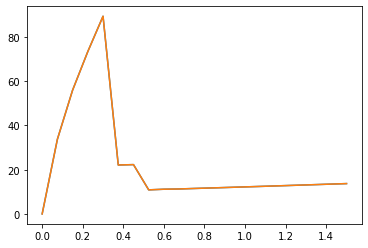

In [8]:
F_l_t = np.sum(F_to[:, bc_l_x.dofs], axis=-1)
F_r_t = np.sum(F_to[:, bc_r_x.dofs], axis=-1)
U_r_t = np.average(U_to[:, bc_r_x.dofs], axis=-1)

A = np.pi * outer_radius**2
import matplotlib.pylab as plt
plt.plot(-U_r_t, -F_r_t/A)
plt.plot(-U_r_t, F_l_t/A)

In [9]:

#mlab.options.backend = 'envisage'

f_strain = mlab.figure()
scene = mlab.get_engine().scenes[-1]
scene.name = 'strain'
strain_viz = Viz3DTensorField(vis3d=m.hist['strain'])
strain_viz.setup()

decorate_figure(f_strain, strain_viz, 200, [70, 20, 0])

# f_stress = mlab.figure()
# scene = mlab.get_engine().scenes[-1]
# scene.name = 'stress'
# stress_viz = Viz3DTensorField(vis3d=m.hist['stress'])
# stress_viz.setup()
#
# decorate_figure(f_stress, stress_viz, 200, [70, 20, 0])

mlab.show()